In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from random import choices
from scipy import stats
import pickle
from scipy.stats import chi2_contingency
import imblearn
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from ctgan import CTGAN
import torch
import sdmetrics
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.single_column import TVComplement, KSComplement
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import itertools
import numpy as np
import random
from random import choices
from scipy import stats
import pickle
from scipy.stats import chi2_contingency
from sklearn.metrics import matthews_corrcoef
from imblearn.under_sampling import CondensedNearestNeighbour

# Target balancing


## Define new metadata:

In [ ]:
data = pd.read_excel('drive/MyDrive/Dissertation/data/train_data_fixedltcs.xlsx')

In [ ]:
data.shape

In [ ]:
admission = list(data.columns)[:7]
target = list(data.columns)[7]
demographics = list(data.columns)[8:18]
hist_drugs =  list(data.columns)[18:1054-540]
pread_drugs = list(data.columns)[1054-540:1054-202]
ltcs = list(data.columns)[1054-202:1053]
diags = list(data.columns)[1053:]

In [ ]:
print(admission[0],admission[-1])
print(target)
print(demographics[0],demographics[-1])
print(hist_drugs[0],hist_drugs[-1])
print(pread_drugs[0],pread_drugs[-1])
print(ltcs[0],ltcs[-1])
print(diags[0],diags[-1])

In [ ]:
binary = ['sex'] + hist_drugs + pread_drugs + ltcs + diags
target = target
continuous = ['age_at_event', 'ltc_count', 'townsend_deprivation_index', 'alcohol_intake_frequency', 'smoking_status',
              'relative_smoking_pack_years', 'ethnic_background', 'BMI', 'body_fat_percentage']

toremove = ['eid', 'first_admi_date','first_discharge_date', 'second_admi_date', 'delta_length', 'admi_meth']

## CTGAN Oversampling

### CTGAN hyperparameter tuning

In [ ]:
df_x_train_real = data[data['readmission_state']==True]
params_Set = list(itertools.product([50, 100, 150, 200, 250, 300, 350, 400, 450, 500], [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]))

for params in params_Set:
    print(params)
    df_metrics = pd.read_excel("metrics/syn_metrics.xlsx")
    epochs_unique = []
    batchsize_unique = []

    for dfparams in df_metrics.params.values:
        split_params = dfparams.split(",")
        epochs_unique.append(split_params[0][1:])
        batchsize_unique.append(split_params[1][:-1])
    tuplas = []
    for idx, val in enumerate(epochs_unique):
        tuplas.append([int(epochs_unique[idx]), int(batchsize_unique[idx])])

    if [int(params[0]), int(params[1])] not in tuplas:
        print('selected', params)
        seed_value = 1
        torch.manual_seed(seed_value)
        np.random.seed(seed_value)
        model = CTGAN(epochs=params[0], batch_size=params[1], verbose=True, cuda=False)
        model.fit(df_x_train_real, binary)
        df_x_train_synthetic = model.sample(27725)
        df_x_train_synthetic.to_excel('syn_data/synthetic_data_{}_{}.xlsx'.format(params[0], params[1]), index = False)
        syn_quality = evaluate_synthetic(df_x_train_real, df_x_train_synthetic, binary, continuous)
        model.save('drive/MyDrive/Dissertation/models/ctgan_{}_{}.pkl'.format(params[0], params[1]))

        syn_metrics_dict = {'params': [params[0], params[1]], 'mean_quality': syn_quality}
        df_metrics = df_metrics.append(syn_metrics_dict, ignore_index=True)
        df_metrics.to_excel("drive/MyDrive/Dissertation/metrics/syn_metrics.xlsx", index=False)

(10, 100)
(10, 200)
(10, 500)
(10, 1000)
(50, 100)
(50, 200)
(50, 500)
(50, 1000)
(100, 100)
(100, 200)
(100, 500)
(100, 1000)
(200, 100)
(200, 200)
(200, 500)
(200, 1000)
(300, 100)
(300, 200)
(300, 500)
(300, 1000)
(400, 100)
selected (400, 100)
Epoch 1, Loss G: -36.7612,Loss D: -11.2344
Epoch 2, Loss G: -18.1063,Loss D:  17.2644
Epoch 3, Loss G: -52.4149,Loss D:  8.8903
Epoch 4, Loss G: -19.1582,Loss D:  7.7153
Epoch 5, Loss G: -39.6791,Loss D:  7.2562
Epoch 6, Loss G: -14.7238,Loss D:  1.9164
Epoch 7, Loss G: -47.4277,Loss D: -6.2403
Epoch 8, Loss G: -34.3297,Loss D: -10.6639
Epoch 9, Loss G: -36.1449,Loss D:  7.3159
Epoch 10, Loss G: -8.8242,Loss D: -5.0178
Epoch 11, Loss G: -21.8038,Loss D: -10.5268
Epoch 12, Loss G: -9.0680,Loss D:  2.7124
Epoch 13, Loss G: -15.7546,Loss D:  4.6959
Epoch 14, Loss G:  3.7485,Loss D:  6.1450
Epoch 15, Loss G: -11.9213,Loss D:  6.7524
Epoch 16, Loss G: -16.1032,Loss D:  3.8478
Epoch 17, Loss G: -2.6657,Loss D:  11.2310
Epoch 18, Loss G:  7.9466,Los

Epoch 184, Loss G:  6.7673,Loss D: -1.8402
Epoch 185, Loss G: -4.1984,Loss D: -6.0125
Epoch 186, Loss G: -20.9393,Loss D:  15.8716
Epoch 187, Loss G:  11.3593,Loss D:  20.7677
Epoch 188, Loss G: -9.1085,Loss D:  9.0993
Epoch 189, Loss G: -32.8810,Loss D:  17.2519
Epoch 190, Loss G:  19.1053,Loss D:  1.3078
Epoch 191, Loss G: -2.7423,Loss D:  30.9580
Epoch 192, Loss G: -11.0317,Loss D:  43.3302
Epoch 193, Loss G:  7.0081,Loss D:  20.2992
Epoch 194, Loss G:  1.1479,Loss D: -29.0357
Epoch 195, Loss G: -18.1025,Loss D: -1.8924
Epoch 196, Loss G: -26.3051,Loss D: -20.1842
Epoch 197, Loss G: -3.7395,Loss D: -11.0155
Epoch 198, Loss G: -13.2727,Loss D:  5.0997
Epoch 199, Loss G:  14.2931,Loss D:  20.5168
Epoch 200, Loss G: -32.5213,Loss D: -30.6320
Epoch 201, Loss G:  20.0817,Loss D:  0.9983
Epoch 202, Loss G:  2.0349,Loss D:  4.8721
Epoch 203, Loss G:  1.1640,Loss D: -39.6952
Epoch 204, Loss G: -12.6100,Loss D:  5.4617
Epoch 205, Loss G:  23.0675,Loss D: -3.9216
Epoch 206, Loss G: -6.2136,Lo

Epoch 370, Loss G: -6.8201,Loss D:  8.8318
Epoch 371, Loss G:  16.6915,Loss D:  7.7701
Epoch 372, Loss G:  1.7951,Loss D: -8.1102
Epoch 373, Loss G:  6.9657,Loss D:  6.6085
Epoch 374, Loss G: -9.4211,Loss D:  8.2121
Epoch 375, Loss G:  6.2391,Loss D:  32.2239
Epoch 376, Loss G: -0.7632,Loss D: -12.5779
Epoch 377, Loss G:  0.0740,Loss D: -3.8061
Epoch 378, Loss G:  4.5118,Loss D:  7.9647
Epoch 379, Loss G:  2.9400,Loss D: -7.9359
Epoch 380, Loss G:  25.2080,Loss D:  10.9232
Epoch 381, Loss G: -15.2206,Loss D: -0.4807
Epoch 382, Loss G: -16.9492,Loss D:  2.4048
Epoch 383, Loss G: -13.5254,Loss D:  20.8007
Epoch 384, Loss G: -11.2512,Loss D:  3.9057
Epoch 385, Loss G:  27.8469,Loss D:  0.7275
Epoch 386, Loss G: -3.8922,Loss D: -4.7778
Epoch 387, Loss G:  12.2194,Loss D:  25.7309
Epoch 388, Loss G: -15.0775,Loss D:  37.2345
Epoch 389, Loss G: -12.1330,Loss D: -11.9006
Epoch 390, Loss G:  29.1177,Loss D:  5.8430
Epoch 391, Loss G:  12.4377,Loss D:  0.6063
Epoch 392, Loss G:  22.9515,Loss D:

/tmp/ipykernel_746432/1625083392.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(syn_metrics_dict, ignore_index=True)


(400, 200)
selected (400, 200)
Epoch 1, Loss G: -32.8846,Loss D:  0.6615
Epoch 2, Loss G: -32.2265,Loss D:  0.6620
Epoch 3, Loss G: -35.2655,Loss D:  3.6764
Epoch 4, Loss G: -35.8801,Loss D:  0.2560
Epoch 5, Loss G: -28.5740,Loss D:  2.1610
Epoch 6, Loss G: -21.0359,Loss D: -8.2525
Epoch 7, Loss G: -24.2108,Loss D: -0.9069
Epoch 8, Loss G: -27.1922,Loss D: -8.2521
Epoch 9, Loss G: -18.6513,Loss D:  4.2830
Epoch 10, Loss G: -27.5785,Loss D:  9.9551
Epoch 11, Loss G: -27.9574,Loss D: -3.0989
Epoch 12, Loss G: -34.8033,Loss D:  8.2575
Epoch 13, Loss G: -28.2555,Loss D: -3.9821
Epoch 14, Loss G: -12.4309,Loss D:  3.4269
Epoch 15, Loss G: -24.6488,Loss D:  0.4634
Epoch 16, Loss G: -11.9925,Loss D: -7.2031
Epoch 17, Loss G: -8.3134,Loss D:  15.1061
Epoch 18, Loss G: -11.8955,Loss D: -12.3611
Epoch 19, Loss G: -7.8244,Loss D: -2.9294
Epoch 20, Loss G:  0.1901,Loss D: -6.8120
Epoch 21, Loss G: -3.1027,Loss D: -13.3802
Epoch 22, Loss G:  4.2800,Loss D: -10.2509
Epoch 23, Loss G:  8.9527,Loss D:

Epoch 191, Loss G: -4.7415,Loss D: -9.3794
Epoch 192, Loss G:  2.9552,Loss D: -3.7143
Epoch 193, Loss G:  2.3734,Loss D: -2.7472
Epoch 194, Loss G:  19.8815,Loss D:  3.8184
Epoch 195, Loss G: -14.8437,Loss D: -6.3205
Epoch 196, Loss G:  3.7869,Loss D: -14.9137
Epoch 197, Loss G: -14.2402,Loss D:  15.1844
Epoch 198, Loss G: -7.3849,Loss D:  6.4832
Epoch 199, Loss G:  15.2461,Loss D: -8.6599
Epoch 200, Loss G:  11.7200,Loss D: -16.6687
Epoch 201, Loss G:  8.1325,Loss D: -15.3638
Epoch 202, Loss G:  9.2063,Loss D:  22.7030
Epoch 203, Loss G: -0.6868,Loss D:  15.9305
Epoch 204, Loss G:  15.4550,Loss D:  5.3443
Epoch 205, Loss G:  15.2069,Loss D:  17.3968
Epoch 206, Loss G:  10.9326,Loss D: -22.7097
Epoch 207, Loss G: -15.7793,Loss D: -8.9619
Epoch 208, Loss G: -21.6032,Loss D: -16.1203
Epoch 209, Loss G:  7.7559,Loss D:  23.6757
Epoch 210, Loss G:  2.8200,Loss D:  1.8018
Epoch 211, Loss G: -2.3629,Loss D: -10.1181
Epoch 212, Loss G: -2.4318,Loss D:  2.8849
Epoch 213, Loss G: -10.4642,Loss 

Epoch 379, Loss G:  3.4730,Loss D:  7.3868
Epoch 380, Loss G: -25.7065,Loss D:  9.8769
Epoch 381, Loss G: -12.3452,Loss D: -12.3673
Epoch 382, Loss G:  0.8332,Loss D: -11.1158
Epoch 383, Loss G:  11.7937,Loss D: -11.6958
Epoch 384, Loss G: -3.0403,Loss D: -11.2626
Epoch 385, Loss G:  1.2513,Loss D: -2.8135
Epoch 386, Loss G:  2.0301,Loss D:  11.2206
Epoch 387, Loss G: -19.5265,Loss D: -12.6536
Epoch 388, Loss G: -2.1070,Loss D: -7.2630
Epoch 389, Loss G: -6.9617,Loss D: -5.8876
Epoch 390, Loss G:  7.8045,Loss D: -7.0344
Epoch 391, Loss G:  11.7913,Loss D: -8.1410
Epoch 392, Loss G: -23.8540,Loss D:  3.5629
Epoch 393, Loss G: -10.0721,Loss D:  7.9077
Epoch 394, Loss G: -3.0317,Loss D:  13.7646
Epoch 395, Loss G: -11.7555,Loss D: -27.7020
Epoch 396, Loss G:  11.5511,Loss D:  4.9369
Epoch 397, Loss G: -25.4984,Loss D: -2.4110
Epoch 398, Loss G:  6.0938,Loss D: -6.6755
Epoch 399, Loss G: -5.1045,Loss D: -2.9021
Epoch 400, Loss G: -25.3829,Loss D:  6.7697


/tmp/ipykernel_746432/1625083392.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(syn_metrics_dict, ignore_index=True)


(400, 500)
selected (400, 500)
Epoch 1, Loss G: -22.8938,Loss D: -12.5076
Epoch 2, Loss G: -27.8039,Loss D: -2.4338
Epoch 3, Loss G: -24.6521,Loss D: -2.5988
Epoch 4, Loss G: -23.0590,Loss D: -2.0210
Epoch 5, Loss G: -23.9375,Loss D: -1.6587
Epoch 6, Loss G: -19.5024,Loss D: -4.0629
Epoch 7, Loss G: -10.8380,Loss D: -0.5669
Epoch 8, Loss G: -14.6022,Loss D:  3.9584
Epoch 9, Loss G: -17.9521,Loss D:  7.8367
Epoch 10, Loss G: -17.5971,Loss D: -2.1613
Epoch 11, Loss G: -20.8295,Loss D: -1.1121
Epoch 12, Loss G: -23.3909,Loss D: -6.1368
Epoch 13, Loss G: -29.6895,Loss D: -1.2543
Epoch 14, Loss G: -28.4647,Loss D:  0.4182
Epoch 15, Loss G: -20.1332,Loss D:  4.5833
Epoch 16, Loss G: -16.4208,Loss D:  2.4073
Epoch 17, Loss G: -15.7712,Loss D:  8.0943
Epoch 18, Loss G: -22.7545,Loss D:  1.6995
Epoch 19, Loss G: -7.7950,Loss D: -6.1265
Epoch 20, Loss G: -17.9841,Loss D: -8.4908
Epoch 21, Loss G: -18.2386,Loss D: -1.7170
Epoch 22, Loss G: -17.9670,Loss D:  5.2179
Epoch 23, Loss G: -13.8815,Loss 

Epoch 192, Loss G: -3.0463,Loss D: -8.4331
Epoch 193, Loss G: -10.3155,Loss D:  1.8037
Epoch 194, Loss G:  1.0653,Loss D: -1.1687
Epoch 195, Loss G: -6.4634,Loss D:  9.1437
Epoch 196, Loss G: -7.3191,Loss D:  3.6077
Epoch 197, Loss G:  1.8316,Loss D: -1.2731
Epoch 198, Loss G:  4.7969,Loss D: -8.2118
Epoch 199, Loss G: -12.6890,Loss D:  0.8674
Epoch 200, Loss G: -5.3507,Loss D:  0.4794
Epoch 201, Loss G:  1.5069,Loss D:  7.1763
Epoch 202, Loss G: -11.1681,Loss D:  2.5002
Epoch 203, Loss G:  4.4232,Loss D:  3.2243
Epoch 204, Loss G: -8.5424,Loss D:  0.0350
Epoch 205, Loss G: -10.8051,Loss D:  4.3458
Epoch 206, Loss G: -11.0545,Loss D:  4.0486
Epoch 207, Loss G: -11.3309,Loss D:  3.7118
Epoch 208, Loss G: -14.8493,Loss D:  0.0650
Epoch 209, Loss G: -6.2656,Loss D: -0.5505
Epoch 210, Loss G: -10.7657,Loss D: -3.2367
Epoch 211, Loss G: -15.2043,Loss D:  4.6119
Epoch 212, Loss G: -12.2213,Loss D: -2.3068
Epoch 213, Loss G: -11.4312,Loss D: -2.8273
Epoch 214, Loss G: -16.2074,Loss D:  5.4326

Epoch 381, Loss G:  11.6945,Loss D: -4.7392
Epoch 382, Loss G: -5.2515,Loss D:  5.6853
Epoch 383, Loss G:  0.2899,Loss D: -5.5762
Epoch 384, Loss G: -5.7871,Loss D:  4.9668
Epoch 385, Loss G: -4.5503,Loss D: -3.0205
Epoch 386, Loss G: -7.5305,Loss D:  1.5474
Epoch 387, Loss G: -4.6694,Loss D:  1.9899
Epoch 388, Loss G: -6.9919,Loss D:  1.2233
Epoch 389, Loss G:  6.0485,Loss D: -4.4886
Epoch 390, Loss G: -8.4006,Loss D:  1.4423
Epoch 391, Loss G: -10.1553,Loss D: -0.1133
Epoch 392, Loss G: -2.1391,Loss D: -5.0135
Epoch 393, Loss G: -3.7766,Loss D:  4.6474
Epoch 394, Loss G: -8.8304,Loss D:  4.4068
Epoch 395, Loss G: -15.4962,Loss D:  0.3336
Epoch 396, Loss G: -7.1475,Loss D:  1.6476
Epoch 397, Loss G: -16.4754,Loss D: -4.1260
Epoch 398, Loss G: -14.5897,Loss D:  4.5171
Epoch 399, Loss G: -23.7842,Loss D: -7.1995
Epoch 400, Loss G: -6.7375,Loss D:  2.5199


/tmp/ipykernel_746432/1625083392.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(syn_metrics_dict, ignore_index=True)


(400, 1000)
selected (400, 1000)
Epoch 1, Loss G:  3.1281,Loss D: -30.3447
Epoch 2, Loss G: -29.0010,Loss D: -13.7645
Epoch 3, Loss G: -32.6203,Loss D: -5.2057
Epoch 4, Loss G: -33.9564,Loss D: -3.7110
Epoch 5, Loss G: -33.7676,Loss D: -0.0446
Epoch 6, Loss G: -34.7557,Loss D: -1.2466
Epoch 7, Loss G: -32.7219,Loss D: -2.7032
Epoch 8, Loss G: -32.5095,Loss D: -0.3319
Epoch 9, Loss G: -28.1976,Loss D: -1.5861
Epoch 10, Loss G: -30.1393,Loss D: -1.7888
Epoch 11, Loss G: -29.9148,Loss D: -2.4826
Epoch 12, Loss G: -29.5806,Loss D:  1.2736
Epoch 13, Loss G: -33.5414,Loss D:  0.4584
Epoch 14, Loss G: -27.3318,Loss D:  1.0624
Epoch 15, Loss G: -25.4103,Loss D: -0.9830
Epoch 16, Loss G: -25.5661,Loss D: -0.5021
Epoch 17, Loss G: -31.8283,Loss D: -1.5165
Epoch 18, Loss G: -31.4033,Loss D: -0.3258
Epoch 19, Loss G: -37.1009,Loss D: -1.8172
Epoch 20, Loss G: -35.4069,Loss D: -1.2828
Epoch 21, Loss G: -29.7021,Loss D: -4.2712
Epoch 22, Loss G: -34.7048,Loss D: -0.2387
Epoch 23, Loss G: -38.0904,Lo

Epoch 192, Loss G: -6.3823,Loss D:  6.0181
Epoch 193, Loss G: -4.9594,Loss D:  5.0803
Epoch 194, Loss G: -10.6658,Loss D: -2.8513
Epoch 195, Loss G:  0.0437,Loss D:  1.1626
Epoch 196, Loss G: -3.2863,Loss D:  6.6856
Epoch 197, Loss G: -2.4626,Loss D: -3.2092
Epoch 198, Loss G: -10.6346,Loss D:  2.6517
Epoch 199, Loss G: -4.2709,Loss D: -3.3311
Epoch 200, Loss G: -8.4199,Loss D:  2.4162
Epoch 201, Loss G: -7.1448,Loss D: -1.2803
Epoch 202, Loss G: -3.3205,Loss D: -0.9583
Epoch 203, Loss G: -5.1720,Loss D: -8.6249
Epoch 204, Loss G: -4.9357,Loss D:  2.3139
Epoch 205, Loss G:  0.5038,Loss D: -10.9666
Epoch 206, Loss G: -5.7319,Loss D:  2.4234
Epoch 207, Loss G:  4.2465,Loss D:  1.6870
Epoch 208, Loss G: -1.5724,Loss D: -0.5655
Epoch 209, Loss G: -9.1619,Loss D:  0.1847
Epoch 210, Loss G: -15.8115,Loss D:  0.7942
Epoch 211, Loss G: -10.1158,Loss D: -0.2999
Epoch 212, Loss G: -12.2414,Loss D: -10.9344
Epoch 213, Loss G: -14.8363,Loss D:  3.9803
Epoch 214, Loss G: -16.9773,Loss D: -2.7416
Ep

Epoch 382, Loss G: -9.4766,Loss D: -3.8543
Epoch 383, Loss G: -1.9760,Loss D:  2.0716
Epoch 384, Loss G: -2.6858,Loss D: -6.5092
Epoch 385, Loss G: -7.3390,Loss D: -6.1405
Epoch 386, Loss G: -6.4360,Loss D: -1.3792
Epoch 387, Loss G:  0.1014,Loss D: -0.3721
Epoch 388, Loss G: -1.8695,Loss D:  3.3843
Epoch 389, Loss G: -5.5262,Loss D:  1.8696
Epoch 390, Loss G:  0.8858,Loss D: -4.6608
Epoch 391, Loss G: -5.2892,Loss D:  3.8634
Epoch 392, Loss G: -1.0451,Loss D: -4.2362
Epoch 393, Loss G: -6.7506,Loss D:  3.6546
Epoch 394, Loss G: -8.9381,Loss D:  5.5505
Epoch 395, Loss G: -7.7900,Loss D: -1.0185
Epoch 396, Loss G:  1.1618,Loss D:  4.1676
Epoch 397, Loss G:  3.2767,Loss D:  0.3309
Epoch 398, Loss G: -4.4631,Loss D: -0.2730
Epoch 399, Loss G:  1.2197,Loss D: -2.2951
Epoch 400, Loss G: -5.4984,Loss D:  3.4662


/tmp/ipykernel_746432/1625083392.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(syn_metrics_dict, ignore_index=True)


(500, 100)
selected (500, 100)
Epoch 1, Loss G: -37.3367,Loss D: -11.0768
Epoch 2, Loss G: -16.1353,Loss D:  15.7884
Epoch 3, Loss G: -46.3382,Loss D:  8.7053
Epoch 4, Loss G: -20.1217,Loss D:  10.4551
Epoch 5, Loss G: -45.9334,Loss D:  12.6568
Epoch 6, Loss G: -17.3075,Loss D:  4.7124
Epoch 7, Loss G: -44.2554,Loss D: -10.9525
Epoch 8, Loss G: -35.0578,Loss D: -4.1547
Epoch 9, Loss G: -35.4768,Loss D: -0.5365
Epoch 10, Loss G: -6.4202,Loss D: -5.9453
Epoch 11, Loss G: -21.3483,Loss D: -16.8950
Epoch 12, Loss G: -17.9103,Loss D:  7.9890
Epoch 13, Loss G: -17.6016,Loss D:  7.4682
Epoch 14, Loss G: -5.4757,Loss D:  6.8606
Epoch 15, Loss G: -15.4009,Loss D:  10.1503
Epoch 16, Loss G: -20.3562,Loss D:  4.7143
Epoch 17, Loss G: -16.5160,Loss D:  5.3159
Epoch 18, Loss G: -6.2271,Loss D: -8.1105
Epoch 19, Loss G: -15.9988,Loss D: -28.0045
Epoch 20, Loss G:  5.0531,Loss D:  9.6384
Epoch 21, Loss G:  6.3297,Loss D: -24.7954
Epoch 22, Loss G:  11.9679,Loss D:  0.2813
Epoch 23, Loss G:  9.8498,Lo

Epoch 189, Loss G: -3.5397,Loss D: -25.0278
Epoch 190, Loss G:  15.5339,Loss D:  8.5921
Epoch 191, Loss G: -0.4208,Loss D: -3.5670
Epoch 192, Loss G: -20.1117,Loss D:  26.6593
Epoch 193, Loss G:  19.3914,Loss D:  2.6323
Epoch 194, Loss G:  24.3920,Loss D: -3.1097
Epoch 195, Loss G: -11.6703,Loss D:  15.4456
Epoch 196, Loss G: -32.7941,Loss D: -2.3639
Epoch 197, Loss G: -17.0317,Loss D: -1.1062
Epoch 198, Loss G:  6.2060,Loss D:  5.4502
Epoch 199, Loss G:  0.0940,Loss D:  20.5991
Epoch 200, Loss G: -22.1276,Loss D: -17.9359
Epoch 201, Loss G:  17.4528,Loss D: -6.6011
Epoch 202, Loss G: -18.1752,Loss D: -31.1458
Epoch 203, Loss G:  15.0041,Loss D:  0.4569
Epoch 204, Loss G: -14.2561,Loss D:  7.1414
Epoch 205, Loss G:  8.6871,Loss D:  22.9103
Epoch 206, Loss G: -26.1845,Loss D:  12.7388
Epoch 207, Loss G:  10.2806,Loss D:  10.6870
Epoch 208, Loss G:  6.9012,Loss D: -16.0673
Epoch 209, Loss G:  19.7386,Loss D:  5.8116
Epoch 210, Loss G: -5.2417,Loss D:  42.4580
Epoch 211, Loss G:  3.8191,L

Epoch 375, Loss G:  9.5604,Loss D:  46.5826
Epoch 376, Loss G: -12.7803,Loss D:  13.4874
Epoch 377, Loss G:  9.8649,Loss D: -7.0804
Epoch 378, Loss G: -14.2282,Loss D:  1.9806
Epoch 379, Loss G:  19.9235,Loss D: -1.5496
Epoch 380, Loss G:  15.2044,Loss D:  3.5312
Epoch 381, Loss G: -26.8876,Loss D: -17.4107
Epoch 382, Loss G: -31.9380,Loss D: -37.2662
Epoch 383, Loss G: -9.8624,Loss D:  12.0147
Epoch 384, Loss G: -16.1066,Loss D: -10.8934
Epoch 385, Loss G:  27.0418,Loss D:  24.5024
Epoch 386, Loss G: -5.5112,Loss D: -15.1443
Epoch 387, Loss G:  2.0739,Loss D: -11.0024
Epoch 388, Loss G: -1.2121,Loss D:  14.0892
Epoch 389, Loss G: -9.7113,Loss D: -11.8344
Epoch 390, Loss G:  1.1407,Loss D:  15.8330
Epoch 391, Loss G: -1.4324,Loss D: -30.7146
Epoch 392, Loss G:  17.7742,Loss D:  8.8785
Epoch 393, Loss G: -33.9899,Loss D:  29.4409
Epoch 394, Loss G:  5.2744,Loss D: -21.4540
Epoch 395, Loss G: -0.6608,Loss D:  4.7668
Epoch 396, Loss G:  8.3224,Loss D:  10.1517
Epoch 397, Loss G:  20.1827,

/tmp/ipykernel_746432/1625083392.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(syn_metrics_dict, ignore_index=True)


(500, 200)
selected (500, 200)
Epoch 1, Loss G: -33.5082,Loss D:  0.0500
Epoch 2, Loss G: -33.1301,Loss D:  1.0456
Epoch 3, Loss G: -37.1688,Loss D:  2.8285
Epoch 4, Loss G: -37.4814,Loss D:  0.2582
Epoch 5, Loss G: -30.3379,Loss D:  3.0840
Epoch 6, Loss G: -26.8179,Loss D: -8.9990
Epoch 7, Loss G: -29.6518,Loss D: -0.3795
Epoch 8, Loss G: -26.8192,Loss D: -8.0891
Epoch 9, Loss G: -20.1576,Loss D:  3.8194
Epoch 10, Loss G: -27.7435,Loss D:  10.0896
Epoch 11, Loss G: -19.4021,Loss D: -2.1300
Epoch 12, Loss G: -24.2816,Loss D:  7.1087
Epoch 13, Loss G: -20.6977,Loss D: -0.6099
Epoch 14, Loss G: -13.0058,Loss D:  2.7751
Epoch 15, Loss G: -21.8700,Loss D:  0.8487
Epoch 16, Loss G: -10.7573,Loss D:  0.6740
Epoch 17, Loss G: -4.2656,Loss D:  12.4497
Epoch 18, Loss G: -18.7248,Loss D: -14.6176
Epoch 19, Loss G: -9.8975,Loss D: -2.0303
Epoch 20, Loss G:  4.1665,Loss D: -9.6275
Epoch 21, Loss G: -4.2077,Loss D: -9.6996
Epoch 22, Loss G:  10.5473,Loss D: -8.1623
Epoch 23, Loss G:  13.8560,Loss D

Epoch 190, Loss G:  9.9584,Loss D: -2.4971
Epoch 191, Loss G:  6.5460,Loss D:  4.7599
Epoch 192, Loss G:  0.4632,Loss D:  3.7274
Epoch 193, Loss G: -6.8826,Loss D:  1.9604
Epoch 194, Loss G:  5.4416,Loss D:  7.1460
Epoch 195, Loss G: -18.6527,Loss D: -1.8301
Epoch 196, Loss G: -5.9792,Loss D: -7.9624
Epoch 197, Loss G: -6.8371,Loss D:  30.5661
Epoch 198, Loss G: -5.7729,Loss D:  12.8577
Epoch 199, Loss G:  12.8821,Loss D:  6.7563
Epoch 200, Loss G:  8.2725,Loss D: -8.1917
Epoch 201, Loss G:  2.1342,Loss D: -12.6024
Epoch 202, Loss G:  16.4880,Loss D:  19.3517
Epoch 203, Loss G: -11.4367,Loss D: -4.2424
Epoch 204, Loss G:  10.3551,Loss D: -6.1585
Epoch 205, Loss G:  7.4456,Loss D:  19.7631
Epoch 206, Loss G:  8.1208,Loss D: -6.0505
Epoch 207, Loss G: -24.5633,Loss D: -6.4228
Epoch 208, Loss G: -17.6745,Loss D: -17.9206
Epoch 209, Loss G: -0.0818,Loss D:  23.0044
Epoch 210, Loss G:  13.2717,Loss D:  12.5970
Epoch 211, Loss G:  3.5741,Loss D: -0.4587
Epoch 212, Loss G: -8.8709,Loss D: -3.

Epoch 378, Loss G: -5.8485,Loss D: -8.5689
Epoch 379, Loss G:  10.7832,Loss D:  8.0567
Epoch 380, Loss G: -6.4652,Loss D: -10.0690
Epoch 381, Loss G: -6.9413,Loss D: -5.2157
Epoch 382, Loss G:  6.5574,Loss D: -3.4841
Epoch 383, Loss G:  6.6426,Loss D: -12.0236
Epoch 384, Loss G: -7.2145,Loss D: -15.5755
Epoch 385, Loss G:  2.8204,Loss D: -15.9242
Epoch 386, Loss G:  11.1391,Loss D: -2.5033
Epoch 387, Loss G: -10.8814,Loss D:  9.3013
Epoch 388, Loss G:  6.2241,Loss D: -1.2350
Epoch 389, Loss G: -9.8913,Loss D: -13.0332
Epoch 390, Loss G:  10.4775,Loss D: -2.3830
Epoch 391, Loss G:  13.4838,Loss D:  4.8095
Epoch 392, Loss G: -13.6823,Loss D:  0.1545
Epoch 393, Loss G: -9.7652,Loss D:  5.6107
Epoch 394, Loss G:  4.6263,Loss D:  7.0094
Epoch 395, Loss G: -7.8632,Loss D: -18.7245
Epoch 396, Loss G: -10.1134,Loss D: -9.0630
Epoch 397, Loss G: -10.4517,Loss D: -16.1735
Epoch 398, Loss G:  0.5154,Loss D: -15.0560
Epoch 399, Loss G: -15.7722,Loss D: -4.5929
Epoch 400, Loss G: -3.1815,Loss D:  7

/tmp/ipykernel_746432/1625083392.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(syn_metrics_dict, ignore_index=True)


(500, 500)
selected (500, 500)
Epoch 1, Loss G: -22.8937,Loss D: -12.5393
Epoch 2, Loss G: -27.7948,Loss D: -2.3718
Epoch 3, Loss G: -24.2667,Loss D: -2.3609
Epoch 4, Loss G: -24.9450,Loss D: -2.1265
Epoch 5, Loss G: -25.4413,Loss D: -2.4564
Epoch 6, Loss G: -22.6463,Loss D: -4.4036
Epoch 7, Loss G: -15.3757,Loss D: -1.6573
Epoch 8, Loss G: -20.2118,Loss D:  3.5891
Epoch 9, Loss G: -26.0428,Loss D:  8.3486
Epoch 10, Loss G: -24.6303,Loss D: -2.0491
Epoch 11, Loss G: -25.1264,Loss D: -1.0040
Epoch 12, Loss G: -25.4219,Loss D: -5.4966
Epoch 13, Loss G: -30.2723,Loss D: -2.2238
Epoch 14, Loss G: -27.4924,Loss D:  1.1578
Epoch 15, Loss G: -20.4545,Loss D:  4.1677
Epoch 16, Loss G: -16.9493,Loss D:  2.8506
Epoch 17, Loss G: -16.3423,Loss D:  8.2779
Epoch 18, Loss G: -24.2061,Loss D:  0.7883
Epoch 19, Loss G: -10.5840,Loss D: -6.5107
Epoch 20, Loss G: -19.7091,Loss D: -7.9050
Epoch 21, Loss G: -19.8849,Loss D: -0.1949
Epoch 22, Loss G: -19.3324,Loss D:  3.9461
Epoch 23, Loss G: -11.9477,Loss

Epoch 192, Loss G: -1.2666,Loss D: -9.3649
Epoch 193, Loss G: -2.9953,Loss D:  2.9957
Epoch 194, Loss G:  5.6177,Loss D: -2.7630
Epoch 195, Loss G: -8.1465,Loss D:  11.1901
Epoch 196, Loss G: -1.4142,Loss D: -1.7446
Epoch 197, Loss G:  6.5204,Loss D: -4.6563
Epoch 198, Loss G:  2.7905,Loss D: -8.1433
Epoch 199, Loss G: -13.9742,Loss D:  1.4220
Epoch 200, Loss G: -4.4817,Loss D:  4.3949
Epoch 201, Loss G:  1.8530,Loss D:  6.5390
Epoch 202, Loss G: -7.9983,Loss D: -2.8767
Epoch 203, Loss G:  3.6211,Loss D:  0.6961
Epoch 204, Loss G: -10.9468,Loss D: -3.1458
Epoch 205, Loss G: -8.4660,Loss D: -0.9552
Epoch 206, Loss G: -12.6880,Loss D:  6.3630
Epoch 207, Loss G: -6.5821,Loss D:  4.1026
Epoch 208, Loss G: -9.9022,Loss D: -1.9164
Epoch 209, Loss G: -2.0022,Loss D:  2.8066
Epoch 210, Loss G: -9.1340,Loss D: -2.6202
Epoch 211, Loss G: -11.2214,Loss D:  5.1474
Epoch 212, Loss G: -9.1444,Loss D: -0.0798
Epoch 213, Loss G: -4.2429,Loss D: -4.3096
Epoch 214, Loss G: -13.5856,Loss D:  3.5430
Epoch

Epoch 381, Loss G:  6.7339,Loss D:  2.7454
Epoch 382, Loss G: -2.1332,Loss D:  3.4459
Epoch 383, Loss G:  0.9540,Loss D: -4.4424
Epoch 384, Loss G:  0.1588,Loss D:  9.3293
Epoch 385, Loss G:  2.9546,Loss D: -2.7575
Epoch 386, Loss G: -3.9805,Loss D:  1.9343
Epoch 387, Loss G:  1.0328,Loss D:  12.3136
Epoch 388, Loss G: -4.6802,Loss D: -3.7074
Epoch 389, Loss G: -0.1059,Loss D: -4.1868
Epoch 390, Loss G: -5.2467,Loss D: -4.4493
Epoch 391, Loss G: -6.3832,Loss D:  2.3311
Epoch 392, Loss G: -9.1974,Loss D: -6.3066
Epoch 393, Loss G: -5.2165,Loss D:  0.3156
Epoch 394, Loss G: -11.6404,Loss D:  8.1864
Epoch 395, Loss G: -14.2126,Loss D: -1.9682
Epoch 396, Loss G: -8.9008,Loss D:  8.4584
Epoch 397, Loss G: -22.0294,Loss D:  1.6745
Epoch 398, Loss G: -14.3575,Loss D:  4.3497
Epoch 399, Loss G: -14.0827,Loss D: -11.9653
Epoch 400, Loss G: -8.6083,Loss D:  0.5770
Epoch 401, Loss G: -16.7379,Loss D: -1.6877
Epoch 402, Loss G: -16.2475,Loss D:  1.2625
Epoch 403, Loss G: -17.9013,Loss D:  7.7983
E

/tmp/ipykernel_746432/1625083392.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(syn_metrics_dict, ignore_index=True)


(500, 1000)
selected (500, 1000)
Epoch 1, Loss G:  2.6738,Loss D: -30.2835
Epoch 2, Loss G: -29.2578,Loss D: -13.4726
Epoch 3, Loss G: -33.4577,Loss D: -5.4552
Epoch 4, Loss G: -34.2596,Loss D: -3.8036
Epoch 5, Loss G: -34.2991,Loss D: -0.0968
Epoch 6, Loss G: -34.8413,Loss D: -1.4881
Epoch 7, Loss G: -32.2475,Loss D: -2.6653
Epoch 8, Loss G: -32.4156,Loss D: -0.1177
Epoch 9, Loss G: -28.0997,Loss D: -1.4380
Epoch 10, Loss G: -29.4358,Loss D: -2.0865
Epoch 11, Loss G: -30.9235,Loss D: -2.5218
Epoch 12, Loss G: -30.3808,Loss D:  1.5821
Epoch 13, Loss G: -34.1684,Loss D:  0.4978
Epoch 14, Loss G: -27.4014,Loss D:  1.5509
Epoch 15, Loss G: -25.2324,Loss D: -0.9253
Epoch 16, Loss G: -25.3294,Loss D:  0.1614
Epoch 17, Loss G: -31.1263,Loss D: -2.1826
Epoch 18, Loss G: -30.8829,Loss D: -0.1363
Epoch 19, Loss G: -36.1040,Loss D: -1.5836
Epoch 20, Loss G: -33.7428,Loss D: -1.0419
Epoch 21, Loss G: -28.7479,Loss D: -3.6804
Epoch 22, Loss G: -33.6478,Loss D: -0.4955
Epoch 23, Loss G: -36.1776,Lo

Epoch 191, Loss G: -15.0327,Loss D:  0.1524
Epoch 192, Loss G: -10.0435,Loss D:  3.4025
Epoch 193, Loss G: -2.8039,Loss D:  6.0851
Epoch 194, Loss G: -6.0134,Loss D: -0.3269
Epoch 195, Loss G:  1.6875,Loss D: -0.7249
Epoch 196, Loss G: -3.3378,Loss D:  7.1714
Epoch 197, Loss G: -6.2293,Loss D:  1.1178
Epoch 198, Loss G: -10.6717,Loss D:  0.3971
Epoch 199, Loss G: -3.2773,Loss D: -5.0631
Epoch 200, Loss G: -0.8227,Loss D: -0.0976
Epoch 201, Loss G: -6.5269,Loss D: -1.7213
Epoch 202, Loss G: -3.0987,Loss D:  2.8599
Epoch 203, Loss G: -11.0287,Loss D: -6.0404
Epoch 204, Loss G: -3.1302,Loss D:  3.7887
Epoch 205, Loss G:  0.2800,Loss D: -13.4543
Epoch 206, Loss G: -2.7890,Loss D:  4.0436
Epoch 207, Loss G: -2.1287,Loss D:  0.0880
Epoch 208, Loss G: -8.8313,Loss D: -0.5362
Epoch 209, Loss G: -10.4995,Loss D: -2.4542
Epoch 210, Loss G: -10.1103,Loss D:  1.4900
Epoch 211, Loss G: -10.3878,Loss D:  1.0303
Epoch 212, Loss G: -18.0202,Loss D: -12.4197
Epoch 213, Loss G: -19.6237,Loss D:  4.2922


Epoch 381, Loss G: -10.7403,Loss D:  3.1143
Epoch 382, Loss G: -21.0334,Loss D: -0.3586
Epoch 383, Loss G: -9.1080,Loss D: -0.1699
Epoch 384, Loss G: -3.9461,Loss D: -7.9207
Epoch 385, Loss G: -4.3892,Loss D: -0.0167
Epoch 386, Loss G: -9.5630,Loss D:  1.8533
Epoch 387, Loss G: -5.4423,Loss D: -0.4924
Epoch 388, Loss G:  0.4983,Loss D: -0.1714
Epoch 389, Loss G: -4.5425,Loss D:  4.2092
Epoch 390, Loss G:  2.3880,Loss D: -3.4524
Epoch 391, Loss G: -4.9892,Loss D:  2.8088
Epoch 392, Loss G: -1.6184,Loss D: -1.5269
Epoch 393, Loss G: -6.4410,Loss D:  1.7384
Epoch 394, Loss G: -8.3142,Loss D:  7.1386
Epoch 395, Loss G: -8.7378,Loss D:  0.4417
Epoch 396, Loss G: -0.7646,Loss D:  2.4293
Epoch 397, Loss G: -1.3790,Loss D:  6.3313
Epoch 398, Loss G: -2.0672,Loss D:  1.8733
Epoch 399, Loss G: -1.5412,Loss D: -5.0811
Epoch 400, Loss G: -6.9116,Loss D:  4.2714
Epoch 401, Loss G: -3.8742,Loss D: -6.0338
Epoch 402, Loss G: -1.8264,Loss D: -1.4564
Epoch 403, Loss G: -2.5478,Loss D: -7.3777
Epoch 404

/tmp/ipykernel_746432/1625083392.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(syn_metrics_dict, ignore_index=True)


### Pairwise correlation difference

In [ ]:
def correlation_study(df, continuous, binary, target):
    corr_vals = []
    variables = [target] + binary + continuous
    binary.append(target)

    for var1 in variables:
        listvar1 = []
        for var2 in variables:
            if var1 in continuous and var2 in continuous:
                corr, _ = stats.pearsonr(df[var1], df[var2])
                listvar1.append(corr)
            if var1 in continuous and var2 in binary:
                pbc, pval = stats.pointbiserialr(df[var2], df[var1])
                listvar1.append(pbc)
            if var1 in binary and var2 in continuous:
                pbc, pval = stats.pointbiserialr(df[var2], df[var1])
                listvar1.append(pbc)
            if var1 in binary and var2 in binary:
                listvar1.append(matthews_corrcoef(df[var2], df[var1]))
        corr_vals.append(listvar1)

    corrdf = pd.DataFrame(corr_vals, columns = variables)
    corrdf['Var'] = variables
    corrdf.set_index('Var', inplace = True)
    corrdf.update(corrdf.abs())
    return corrdf, corr_vals

def compute_pairwise_corr_difference(corrorig, corrsyn):
    corrorig = corrorig.loc[:,~corrorig.columns.duplicated()].copy()
    corrorig = corrorig.loc[~corrorig.index.duplicated(),:].copy()
    corrorig = corrorig.fillna(0)

    corrsyn = corrsyn.loc[:,~corrsyn.columns.duplicated()].copy()
    corrsyn = corrsyn.loc[~corrsyn.index.duplicated(),:].copy()
    corrsyn = corrsyn.fillna(0)

    diff_mat = corrorig.values - corrsyn.values
    pcd = np.linalg.norm(diff_mat)
    return pcd

In [ ]:
original_corr = pd.read_excel('drive/MyDrive/Dissertation/metrics/correlation_minority_class.xlsx')

hecho 100 1000
hecho 200 100
hecho 200 200
hecho 200 500
hecho 200 1000


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

19.385506555907238
hecho 300 100


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

13.564950677122065
hecho 10 100


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

13.818569038651816
hecho 50 100


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

14.54979730671803
hecho 100 100


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

13.759253332267456
hecho 300 200


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

13.73085317756247
hecho 300 500


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

13.777469261787534
hecho 300 1000


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

20.930322672554254
hecho 400 100


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

13.87625104568436
hecho 400 200


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

13.698229784633329
hecho 400 500


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

13.718446252707613
hecho 400 1000


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

20.163406886713254
hecho 500 100


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

14.574640472277647
hecho 500 200


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

13.79988806781155
hecho 500 500


/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/hugo/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInpu

13.731231539011441
hecho 500 1000


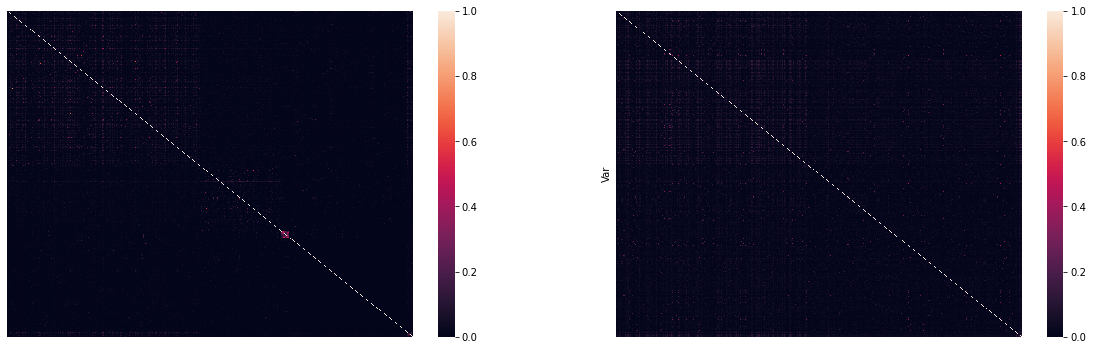

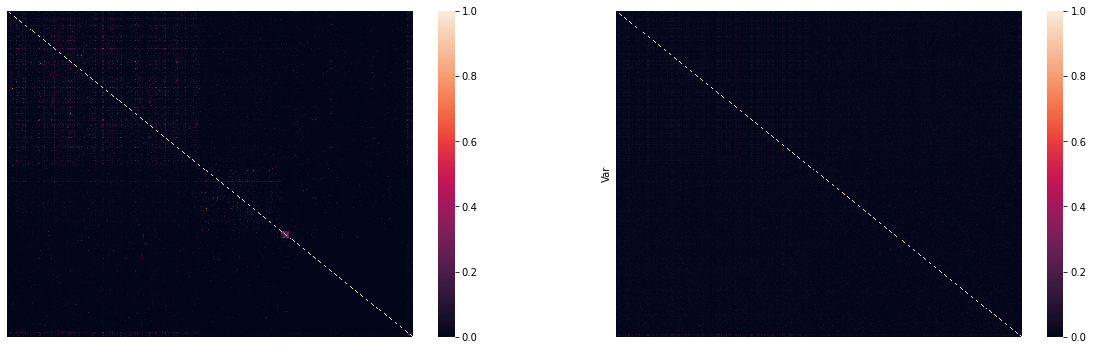

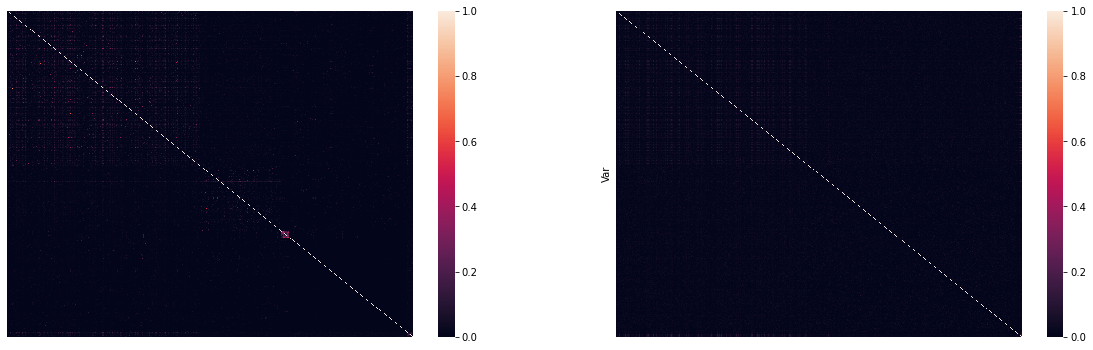

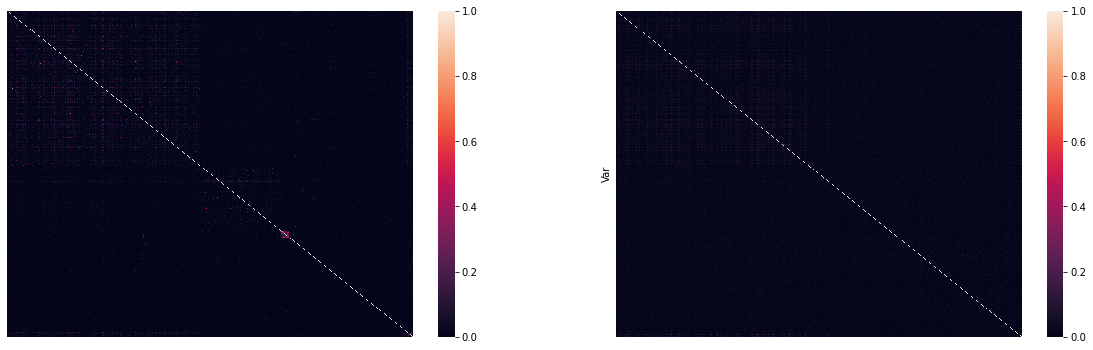

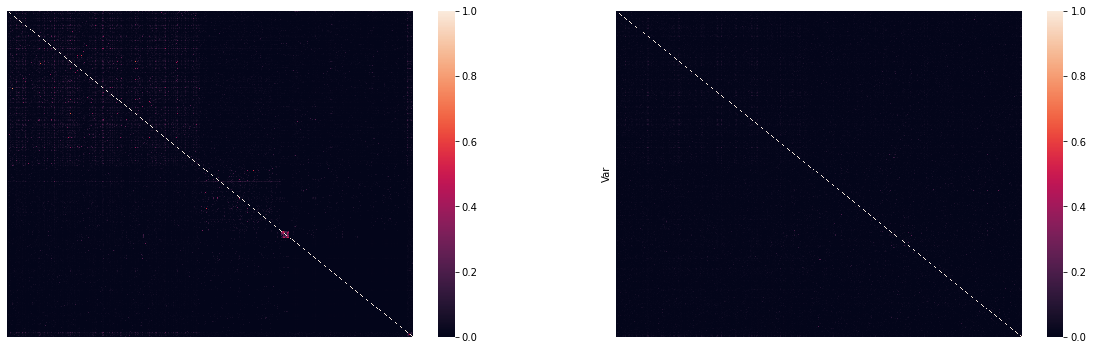

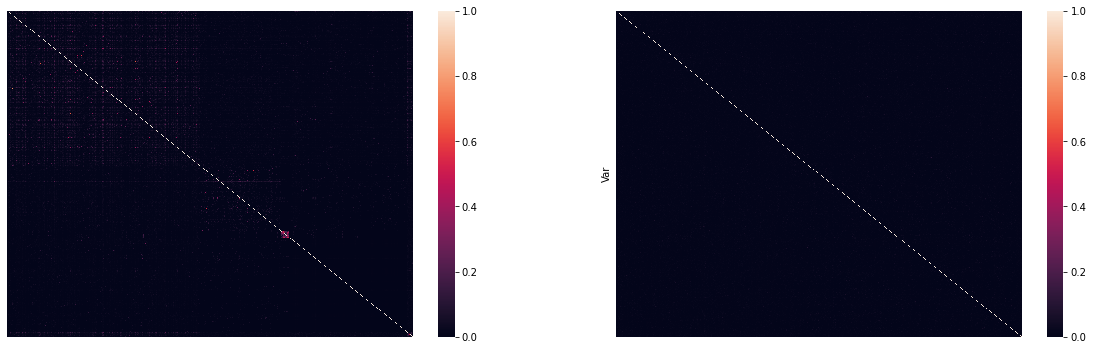

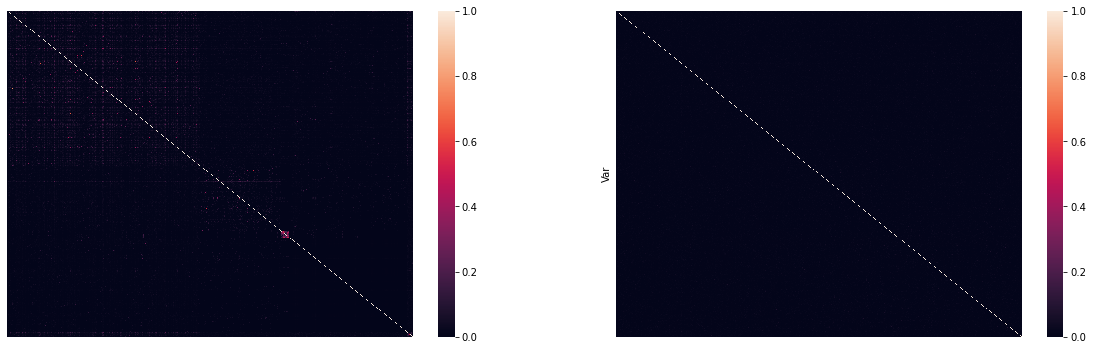

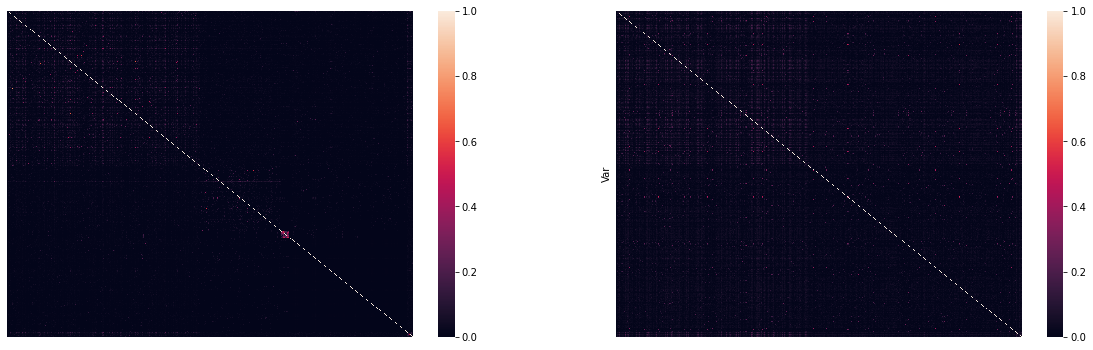

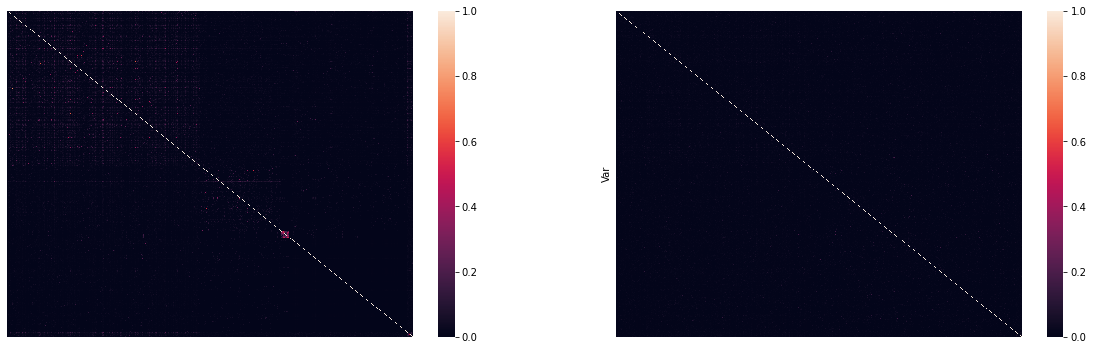

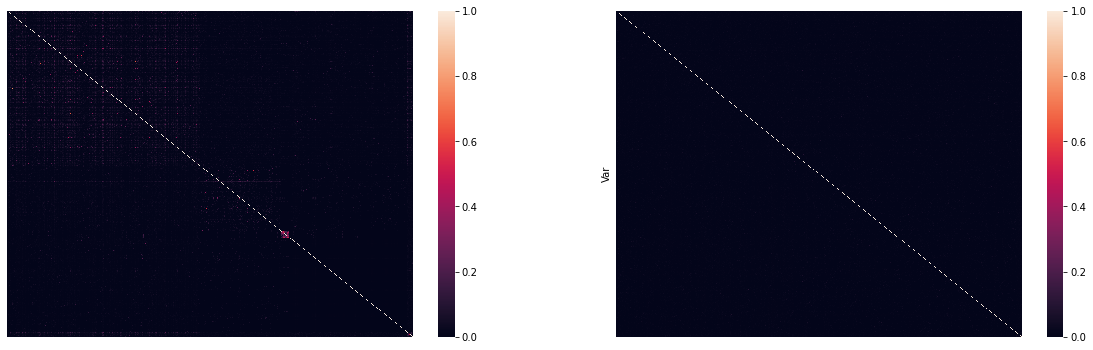

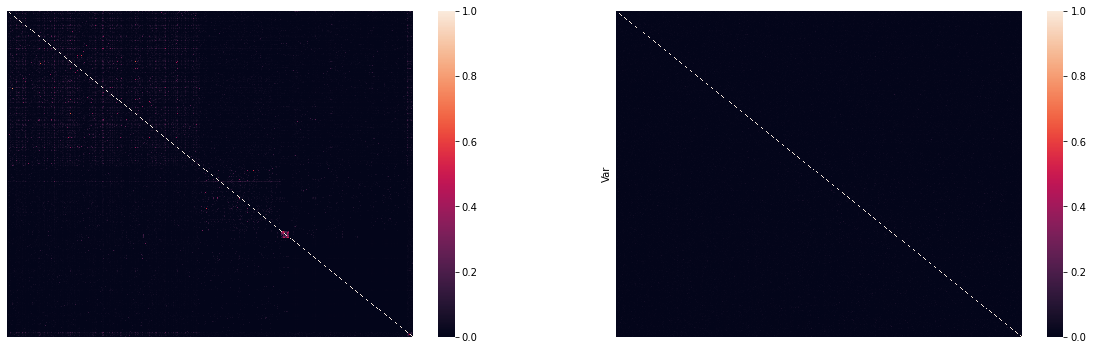

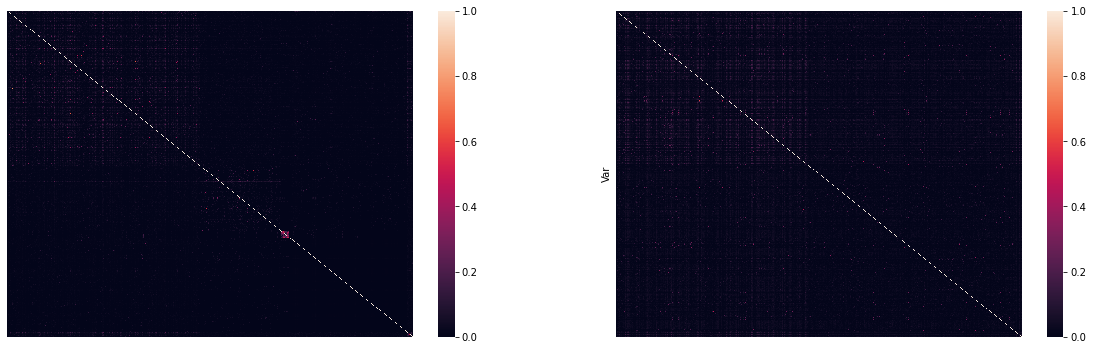

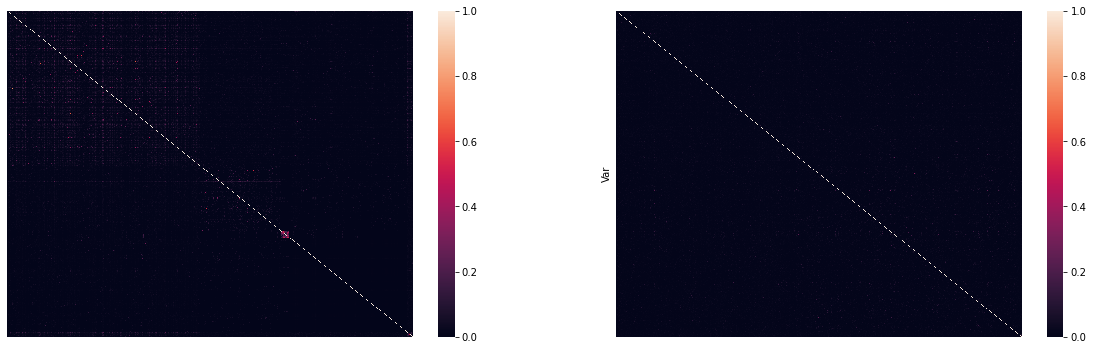

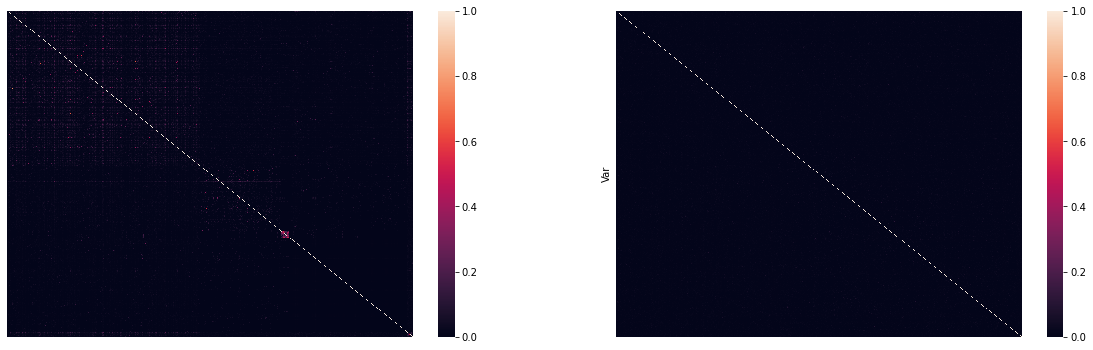

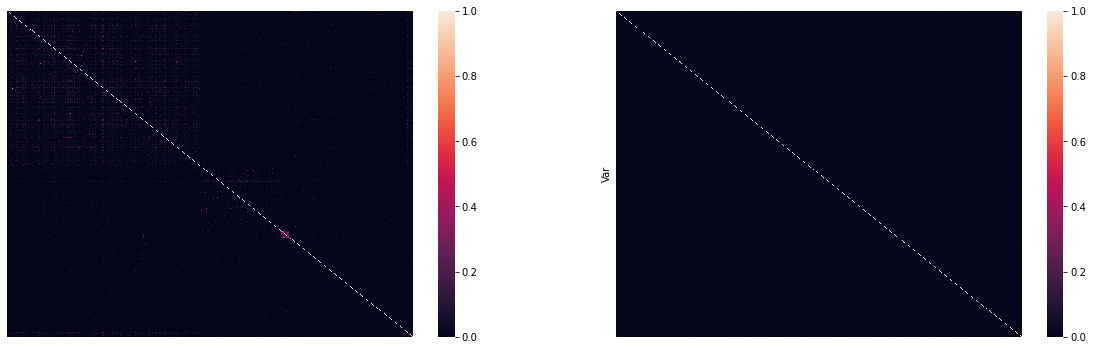

In [ ]:
df_metrics = pd.read_excel("drive/MyDrive/Dissertation/metrics/syn_metrics.xlsx")
df_metrics = df_metrics.iloc[4:,:]
for dfparams in df_metrics.params.values:
    split_params = dfparams.split(",")

    selected_rows = df_metrics[df_metrics['params'] == dfparams]
    for index, row in selected_rows.iterrows():
        if row['pcd'] == "none_yet": # Select only rows where pcd has not already been included.
            dfsyn = pd.read_excel('syn_data/synthetic_data_{}_{}.xlsx'.format(int(split_params[0][1:]),  int(split_params[1][:-1])))
            if 'Unnamed: 0' in dfsyn.columns:
                dfsyn.drop('Unnamed: 0', axis = 1, inplace = True)
                dfsyn.to_excel('syn_data/synthetic_data_{}_{}.xlsx'.format(int(split_params[0][1:]),  int(split_params[1][:-1])), index = False)

            # Compute correlation
            corrsyn, corr_vals_syn = correlation_study(dfsyn, continuous, binary, target)
            # Compute PCD
            pcd = compute_pairwise_corr_difference(original_corr, corrsyn)
            # Add the value to the dfmetrics file
            df_metrics.loc[df_metrics['params'] == dfparams, 'pcd'] = pcd
            df_metrics.to_excel("metrics/syn_metrics.xlsx", index = False)
            print(pcd)

        print('hecho', int(split_params[0][1:]),  int(split_params[1][:-1]))